### event detection by MCMC
test switch point 

- hypo:

> early current: normal distribution

> late current: normal distribution

> switch point: descrete uniform distribution

- test:

> MCMC simulation

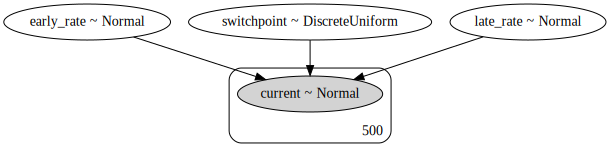

In [73]:
pm.model_to_graphviz(disaster_model)

### model testing

_poisson model_

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [7]:
np.random.seed(123)
disaster_data = np.random.poisson(5, 100)
years = np.arange(0,len(disaster_data))

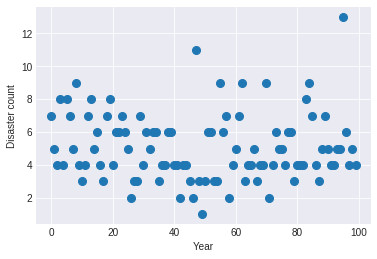

In [9]:
plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [11]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

In [12]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:31<00:00, 1330.54draws/s]
There were 1874 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5832366290866102, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4566 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35155112787182385, but should be close to 0.8. Try to increase the number of tuning steps.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.662393750709136, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight probl

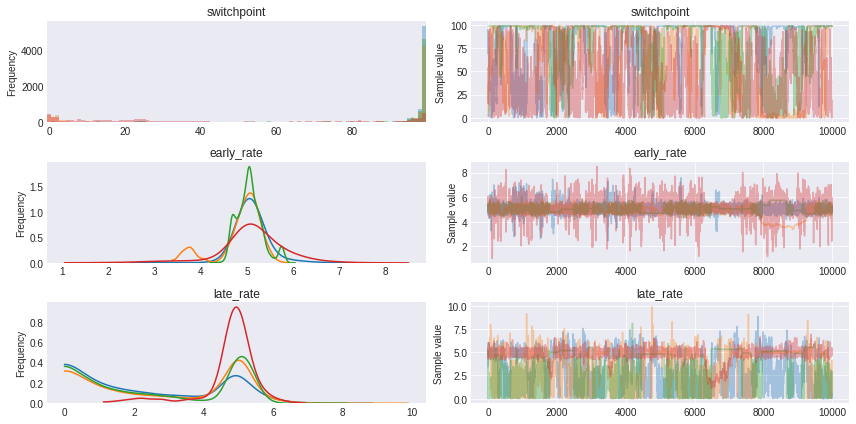

In [13]:
pm.traceplot(trace);

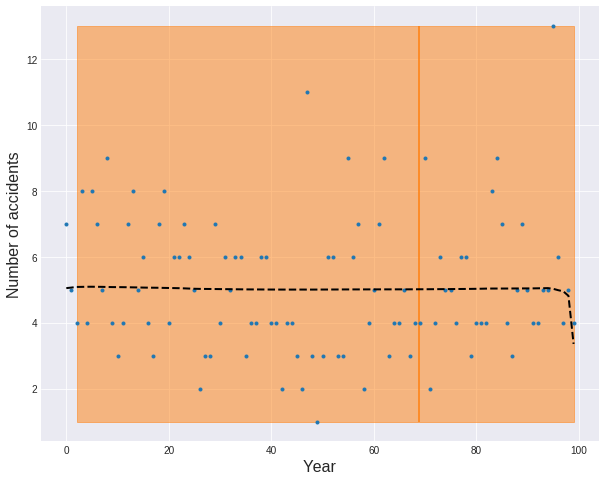

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);

In [16]:
trace['switchpoint'].mean()

68.760475

In [17]:
trace['switchpoint'].var()

1319.1276527743748

In [18]:
trace['early_rate']

array([4.63017425, 5.07455134, 4.75844501, ..., 5.94444928, 5.3126904 ,
       5.48060274])

In [19]:
trace['late_rate']

array([3.46169002, 3.56271624, 3.77130059, ..., 5.00576876, 5.4323315 ,
       4.84483824])

In [20]:
import scipy as sp

In [21]:
sp.stats.ttest_ind(trace['early_rate'], trace['late_rate'])

Ttest_indResult(statistic=162.05025998906666, pvalue=0.0)

In [22]:
np.sqrt(4770)

69.06518659932803

### simulated data testing

#### case 1

__contain different__

In [56]:
np.random.seed(123)
disaster_data = np.zeros(500)
disaster_data[0:250] = np.random.normal(200,70,250)
disaster_data[250:500] = np.random.normal(300,70,250)

years = np.arange(0, len(disaster_data))

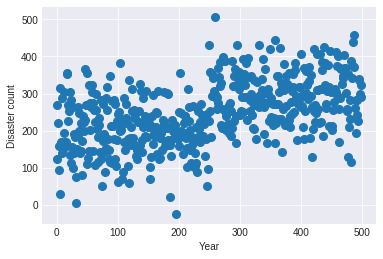

In [57]:
plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [58]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Normal('early_rate', mu=0, sd=1000)
    late_rate = pm.Normal('late_rate', mu=0, sd=1000)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Normal('current', mu=rate, sd=70, observed=disaster_data)

In [59]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:13<00:00, 3166.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


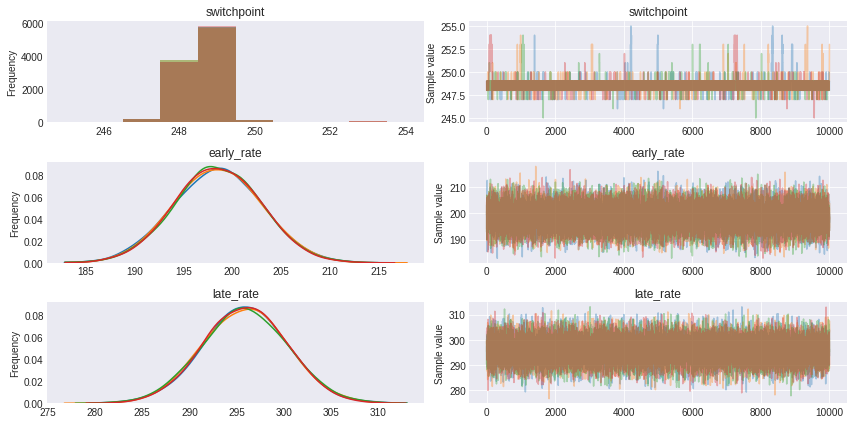

In [60]:
pm.traceplot(trace);

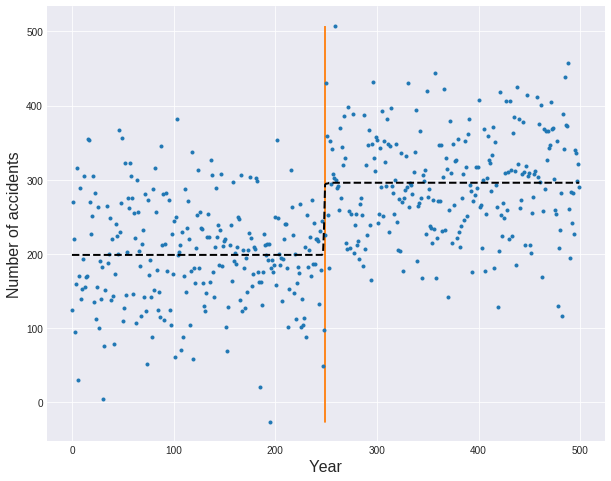

In [62]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);

#### case 2

__same event___

In [63]:
np.random.seed(123)
#disaster_data = np.zeros(500)
disaster_data = np.random.normal(200,70,500)
#disaster_data[250:500] = np.random.normal(300,70,250)

years = np.arange(0, len(disaster_data))

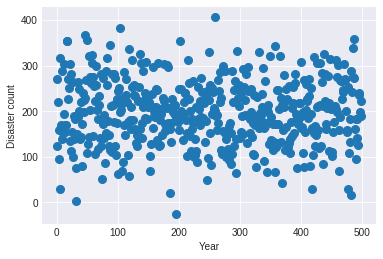

In [64]:
plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [67]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Normal('early_rate', mu=0, sd=1000)
    late_rate = pm.Normal('late_rate', mu=0, sd=1000)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Normal('current', mu=rate, sd=70, observed=disaster_data)

In [68]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:53<00:00, 785.05draws/s]
There were 4356 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27348694812138064, but should be close to 0.8. Try to increase the number of tuning steps.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4882689577812904, but should be close to 0.8. Try to increase the number of tuning steps.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6235427015821805, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2531 divergences after tuning. Increase `target_accept` or reparameterize.
The accept

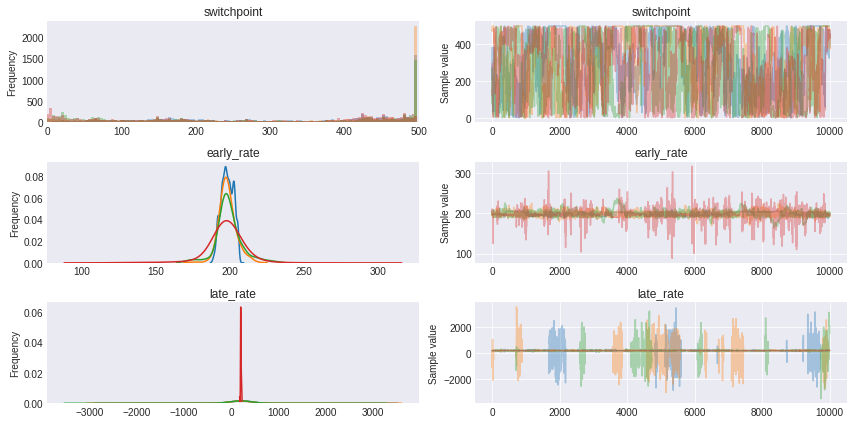

In [69]:
pm.traceplot(trace);

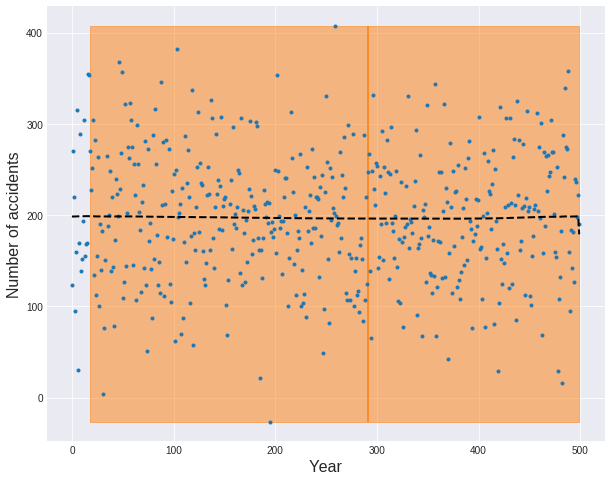

In [70]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1286.80draws/s]
There were 677 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.25624040222650957, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6805253203454261, but should be close to 0.8. Try to increase the number of tuning steps.
There were 608 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33774065182536966, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7163142325682968, but should be clos

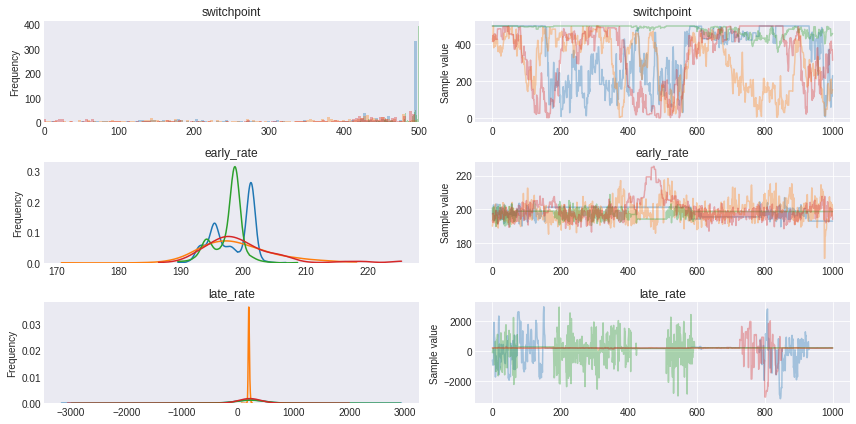

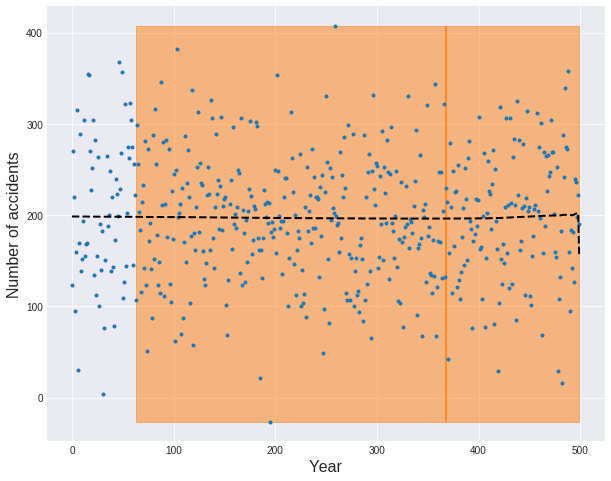

In [75]:
with disaster_model:
    trace = pm.sample(1000)

pm.traceplot(trace);
    
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);